In [100]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib as mpl
import tensorflow as tf
from pandas import Series
from numpy import log
from time import time
from pandas import datetime
from formulas import *
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline
keras = tf.keras

C:\Users\Chandroo\AppData\Local\Temp/ipykernel_8544/2189495101.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [101]:
# initializing the ticker symbol
apple_ticker = 'AAPL'

#importing the data from Yahoo finance corresponding to the Ticker Symbol
apple_ticker = yf.Ticker(apple_ticker)

#importing the Historical Stock Price Data within a given date range
hist = apple_ticker.history(start='2015-1-1', end='2020-1-1', interval='1d')
#saving the importted data into a CSV file
hist.to_csv('../AAPL.CSV')
apple_ticker_dataframe = pd.read_csv('../AAPL.csv')
apple_ticker_dataframe['Date'] = pd.to_datetime(apple_ticker_dataframe['Date'])

apple_ticker_dataframe = apple_ticker_dataframe.dropna()
apple_df = apple_ticker_dataframe[['Close','Date']]
apple_df_copy = apple_ticker_dataframe[['Close','Date']]

In [103]:
# Creating a training data set
train_split_date = '2019-01-03'
train_split_index = np.where(apple_ticker_dataframe.Date == train_split_date)[0][0]
x_train = apple_ticker_dataframe.loc[apple_ticker_dataframe.Date <= train_split_date]['Close']

# Creating a test data set
test_split_date = '2019-01-03'
test_split_index = np.where(apple_ticker_dataframe.Date == test_split_date)[0][0]
x_test = apple_ticker_dataframe.loc[apple_ticker_dataframe.Date >= test_split_date]['Close']

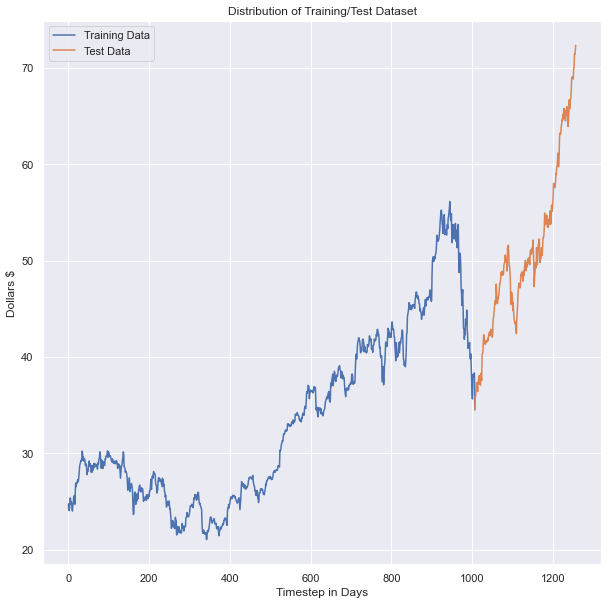

In [104]:
# Setting style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Creating a plot showing the distribution of the training, and test datas
plt.plot(x_train, label = 'Training Data')
plt.plot(x_test, label = 'Test Data')
plt.title('Distribution of Training/Test Dataset')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

In [105]:
# Prepare data
apple_df.loc[apple_df.index,'Year'] = pd.DatetimeIndex(apple_df.Date).year
apple_df.loc[apple_df.index,'Month'] = pd.DatetimeIndex(apple_df.Date).month
years = apple_df['Year'].unique() 

C:\Users\Chandroo\anaconda3\envs\ev_2\lib\site-packages\pandas\core\indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value


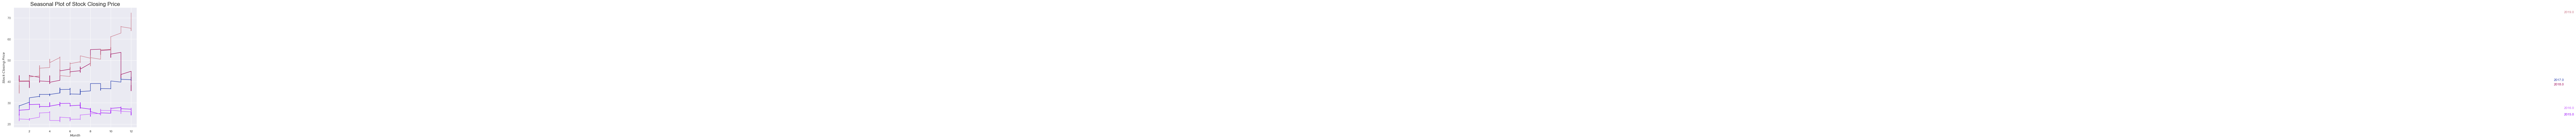

In [106]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(8,8), dpi= 80)
for i, y in enumerate(years):
    if i >= 0: 
        plt.plot('Month', 'Close', data=apple_df.loc[apple_df.Year==y, :], color=mycolors[i], label=y)
        plt.text(apple_df.loc[apple_df.Year==y, :].shape[0]-.9, apple_df.loc[apple_df.Year==y, 'Close'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        

# Decoration
plt.gca().set(ylabel='$Stock$ $Closing$ $Price$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Stock Closing Price", fontsize=20)
plt.show()        

# Naive Forecast Model

In [107]:
naive_forecast = apple_df[test_split_index-1 :-1]

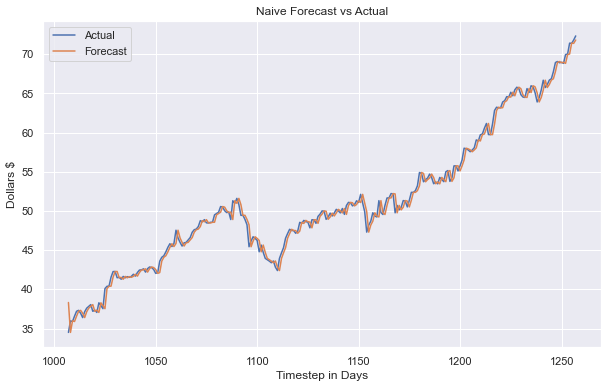

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test.values, label="Actual")
plt.plot(x_test.index, naive_forecast.Close, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')
plt.legend()

In [110]:
#Creating a dictionary to store all of our model training scores
model_mae_scores = {}
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test.values, naive_forecast.Close).numpy()
model_mae_scores['rolling_origin_forecast'] = 1.5080334700778566
model_mae_scores['naive'] = naive_forecast_mae
model_mae_scores

{'rolling_origin_forecast': 1.5080334700778566, 'naive': 0.5775204084783907}

# Simple Moving Average Model

In [111]:
def simple_moving_avg(window):
    # Create a moving average over the entire dataset
    moving_avg = apple_df['Close'].rolling(window=window).mean()

    # Slice the moving average on the forecast
    moving_avg_forecast = moving_avg.values[test_split_index - window:apple_df.index.max() - window + 1]
                                         
    plt.figure(figsize=(10, 6))
    plt.plot(x_test.index, x_test, label="Actual Stock Price")
    plt.plot(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
    plt.ylabel('Dollars $')
    plt.xlabel('Timestep in Days')
    plt.title('SMA20 vs Actual')
    plt.legend()
    sma_forecast_mae = keras.metrics.mean_absolute_error(x_test.values, moving_avg_forecast).numpy()
    return sma_forecast_mae

### Weekly Simply Moving Average (5 Days) 

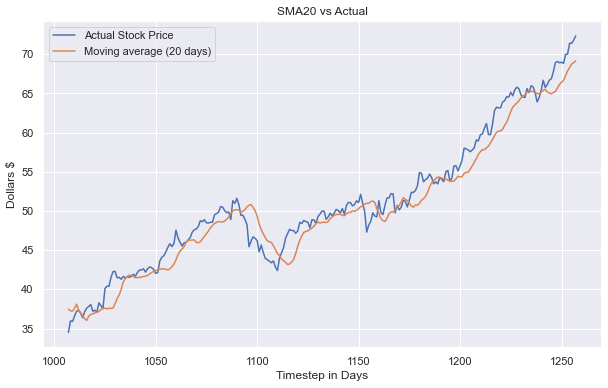

In [112]:
# Setting the window size to 5, because there are 5 working/tradeable days in a week
window = 5
model_mae_scores['moving_average_5'] = simple_moving_avg(window)

### Monthly Simply Moving Average (20 Days)

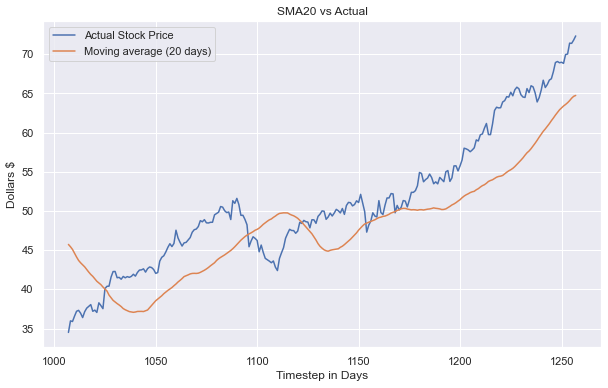

In [113]:
# Setting the window size to 20, because there are 20 working/tradeable days in a month
window = 20
model_mae_scores['moving_average_20'] = simple_moving_avg(window)

In [114]:
model_mae_scores

{'rolling_origin_forecast': 1.5080334700778566,
 'naive': 0.5775204084783907,
 'moving_average_5': 1.5677162474370097,
 'moving_average_20': 4.575504908618698}

# Checking for Stationarity of Time Series

In [115]:
split = round(len(apple_df) / 2)
X1, X2 = apple_df.Close[0:split], apple_df.Close[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=27.319563, mean2=46.310968
variance1=14.045674, variance2=62.818187


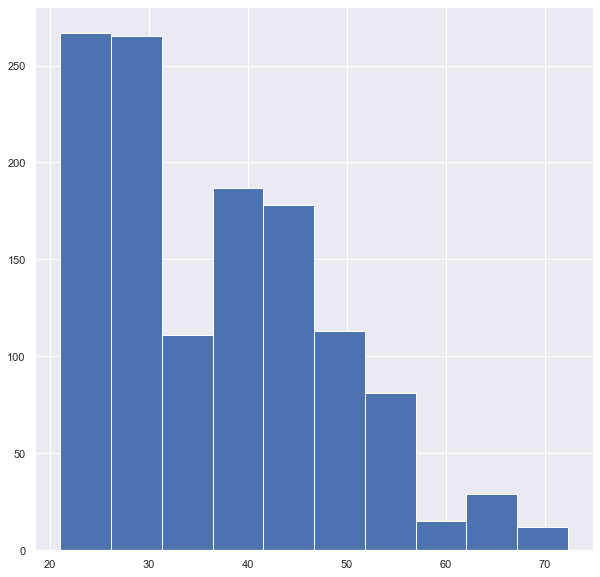

In [117]:
apple_df.Close.hist()
plt.show()

In [118]:
split = round(len(apple_df) / 2)
X = log(apple_df.Close)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.298580, mean2=3.821761
variance1=0.017764, variance2=0.026447


### ACF Plot

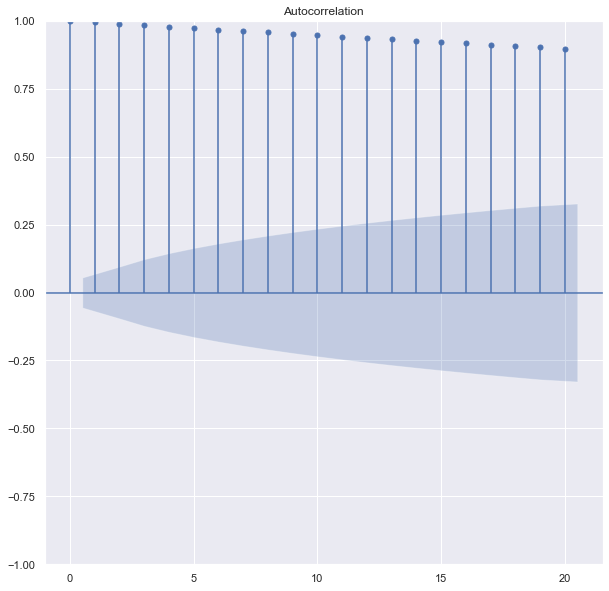

In [119]:
acf_plot = plot_acf(apple_df.Close, lags=20)

### PACF Plot

C:\Users\Chandroo\anaconda3\envs\ev_2\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


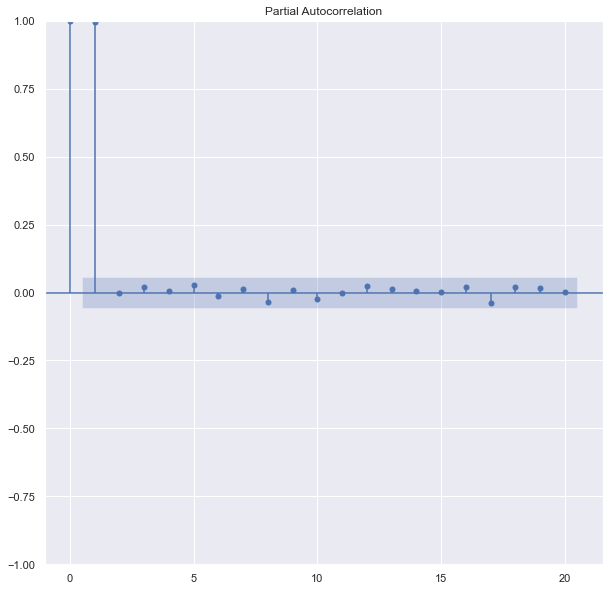

In [120]:
pacf_plot = plot_pacf(apple_df.Close, lags=20)

### Augmented Dicky-Fuller Test

In [121]:
# Function implementing Augmented Dicky-Fuller Test
def stationarity_test(apple_timeseries, window = 10, cutoff = 0.01):

    #Determing rolling statistics
    rolling_mean = apple_timeseries.rolling(window).mean()
    rolling_std = apple_timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(apple_timeseries, color='blue',label='Actual Time Series')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(apple_timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

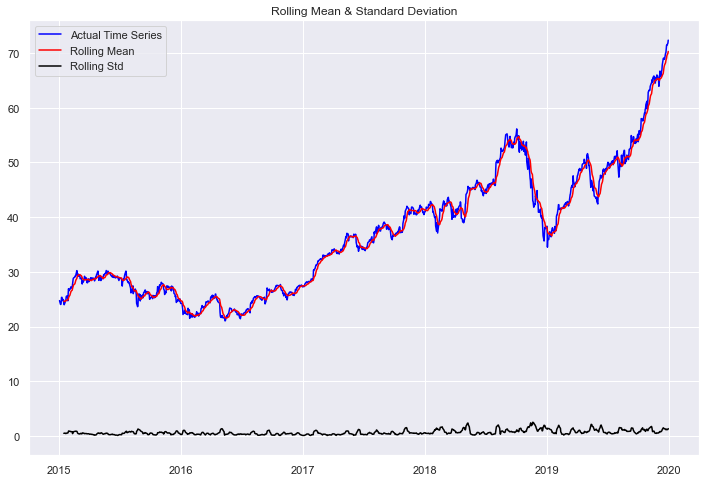

Results of Dickey-Fuller Test:
p-value = 0.9952. The series is likely non-stationary.
Test Statistic                    1.096597
p-value                           0.995187
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


In [122]:
# checking for stationarity 
stationarity_test(hist['Close'])

In [123]:
# performing first-order differencing on Apple daily close prices 
aapl_close_diff = hist['Close'].diff()
aapl_close_diff.dropna(inplace=True)

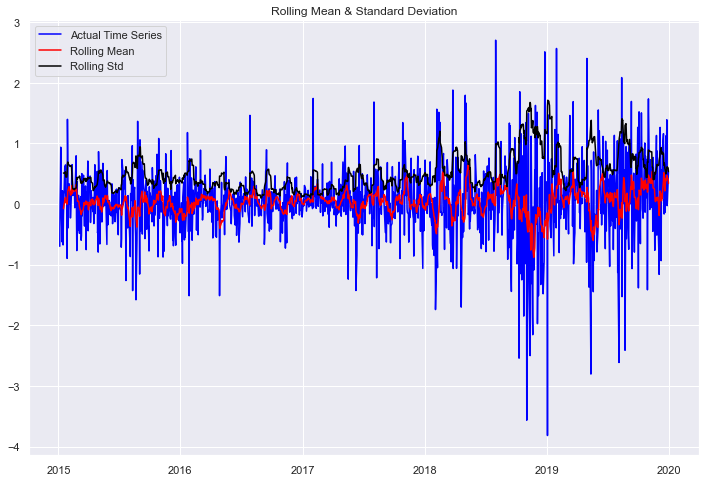

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.033149e+01
p-value                        2.834816e-18
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


In [124]:
stationarity_test(aapl_close_diff)

### ACF Plot

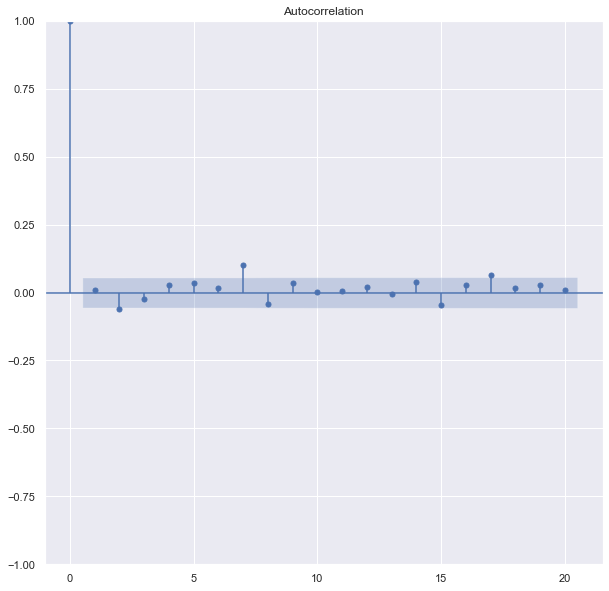

In [125]:
acf_plot = plot_acf(aapl_close_diff, lags=20)

### PACF Plot

C:\Users\Chandroo\anaconda3\envs\ev_2\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


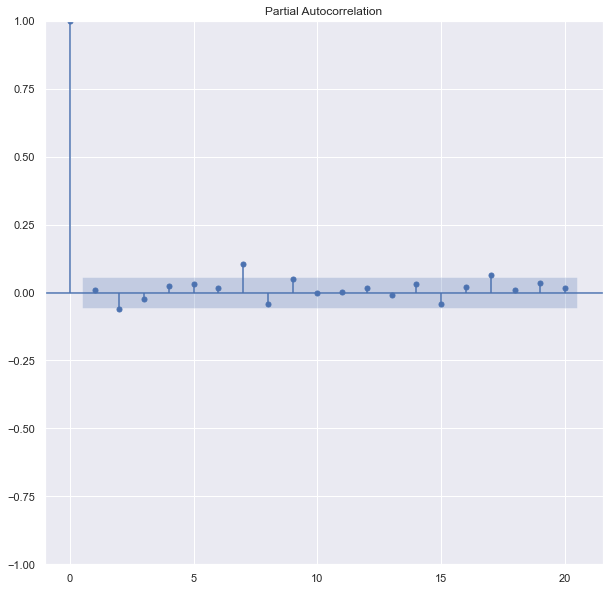

In [126]:
pacf_plot = plot_pacf(aapl_close_diff, lags=20)

## ARIMA Model

In [127]:
# fit model
aapl_arima = ARIMA(x_train, order=(3,1,0))
aapl_arima_fit = aapl_arima.fit()
print(aapl_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -822.208
Date:                Sat, 11 Dec 2021   AIC                           1652.416
Time:                        20:22:12   BIC                           1672.075
Sample:                             0   HQIC                          1659.885
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0364      0.023      1.562      0.118      -0.009       0.082
ar.L2         -0.0606      0.023     -2.666      0.008      -0.105      -0.016
ar.L3         -0.0270      0.023     -1.179      0.2

In [128]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)

%store model_predictions

Stored 'model_predictions' (list)


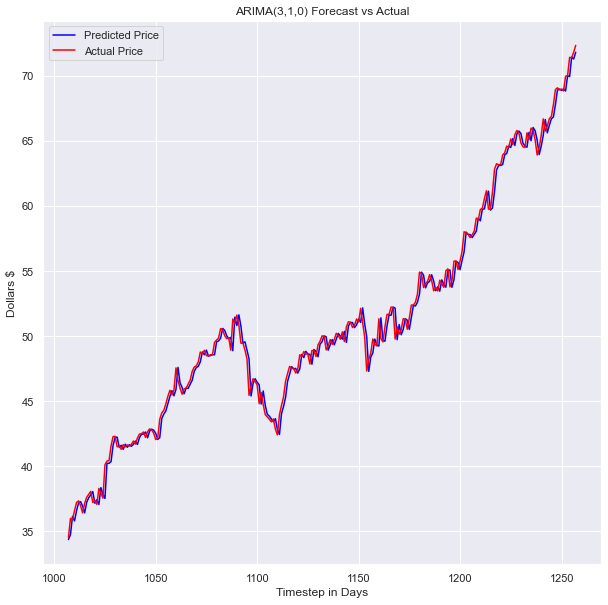

<Figure size 720x432 with 0 Axes>

In [129]:
# Plotting our predictions against the actual values
plt.plot(x_test.index, model_predictions, color='blue',label='Predicted Price')
plt.plot(x_test.index, x_test, color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(3,1,0) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [130]:
# Find the Error in the ARIMA Model
model_predictions = np.array(model_predictions).flatten()
x_test = np.array(x_test).flatten()
arima_error = model_predictions - x_test
dfr=pd.DataFrame({'Actual_Price':x_test, 'Predicted_Price':model_predictions, 'Arima_Error':arima_error})
dfr

,Actual_Price,Predicted_Price,Arima_Error
0,34.508717,34.357343,-0.151373
1,35.981861,34.738729,-1.243133
2,35.901775,36.133307,0.231532
3,36.586174,35.786640,-0.799534
4,37.207466,36.580539,-0.626927
...,...,...,...
246,70.027313,69.998895,-0.028418
247,71.416664,69.947627,-1.469038
248,71.389580,71.432041,0.042462
249,71.813286,71.290191,-0.523095


In [131]:
# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'rolling_origin_forecast': 1.5080334700778566,
 'naive': 0.5775204084783907,
 'moving_average_5': 1.5677162474370097,
 'moving_average_20': 4.575504908618698,
 'ARIMA': 0.564430480072878}